# This code is to show three different head directions cells recorded in the anteroventral thalamic nucleus (AV), i.e., classic HD cells, theta modulated HD cells but without theta skipping, theta skipping HD cells. Experimental data is based on Lomi et al, 2023. This code is written by Zilong Ji, 2024. 

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from numpy import deg2rad
import HD_utils
import seaborn as sns

import sys
sys.path.append('/home/zilong/Desktop/HDPhasePrecession/CircularLinearReg')
from core import cl_corr

%load_ext autoreload
%autoreload 2

In [2]:
def plot_head_direction_tuning(ax, ppoh, psph, pval, hd_mean, hd_std, tune_width, cell_name, config, pos_tb=0.02):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str

        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """

    # Convert angles to radians
    ppoh_rad = deg2rad(ppoh)
    psph_rad = deg2rad(psph)

    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(ppoh_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))
    hd2, _ = np.histogram(psph_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time

    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.max(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(0, 2 * np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #keep 0 90 180 270 as the xticks
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0°', '90°', '180°', '270°'])
    
    #remove yticks
    ax.set_yticks([])
    
    #ax.set_title(cell_name + '\n'+str(np.round(hd_mean,1))+'('+str(np.round(hd_std,1))+')' +'\nRayleigh_p=' + str(np.round(pval, 4)), fontsize=10)
    
    #ax.set_title(f"{cell_name}\nAngle:{hd_mean:.0f} ({hd_std:.0f})\nTuning width:{tune_width:.0f}\nRayleigh_p={pval:.4f}", fontsize=10)
    # ax.legend()
    #set x and y tick as 8 pt
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    return ax

def plot_spike_map(ax, ppox, ppoy, spikearray):
    ppox = ppox.astype(float).flatten()
    ppoy = ppoy.astype(float).flatten()
    ax.plot(ppox, ppoy, 'k', linewidth=0.2, alpha=0.8)
    
    #indexing ppox and ppoy using spikearray and do a scatter plot with red dot
    #convert spikearray to boolean
    spikeindex = spikearray.astype(bool)
    ax.scatter(ppox[spikeindex], ppoy[spikeindex], color='red', s=0.2, alpha=1.0)
    
    #equal 
    ax.set_aspect('equal')
    #remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    #remove spines using seaborn
    sns.despine(ax=ax, left=True, bottom=True)
    
    return ax
    

def plot_autocorrelogram(ax, autocorrelogram, cell_type):
    
    ax.plot(autocorrelogram[1,:], autocorrelogram[0,:], 'k')
    #fillin between y=0 and autocorrelogram
    ax.fill_between(autocorrelogram[1,:], 0, autocorrelogram[0,:], facecolor='black')
    ax.set_xticks([-500, 0, 500])
    ax.set_yticks([])
    ax.set_xlabel('Lag (ms)', fontsize=10)
    # ax.set_title(cell_type)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    
    return ax

def get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config):
    
    spike_phase = spike_phase + np.pi #[-pi, pi] -> [0, 2pi]
    
    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = HD_utils.calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)
    
    #convert psph to radian
    psph = deg2rad(psph)
    hd_mean = deg2rad(hd_mean)
    
    psph_centered = np.mod(psph - hd_mean + np.pi, 2 * np.pi)
    
    #CCW plot in ax1
    continuous_periods_CCW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    indx = []
    for i in range(len(continuous_periods_CCW)):
        indx.extend(np.where((pspt > continuous_periods_CCW[i][0]) & (pspt < continuous_periods_CCW[i][1]))[0])
        
    psph_CCW = psph_centered[indx]
    spike_phase_CCW = spike_phase[indx]
    
    
    #CW plot in ax2
    continuous_periods_CW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)
    #keep the index when pspt is within continuous_periods
    indx = [] 
    for i in range(len(continuous_periods_CW)):
        indx.extend(np.where((pspt > continuous_periods_CW[i][0]) & (pspt < continuous_periods_CW[i][1]))[0])
    
    psph_CW = psph_centered[indx]
    spike_phase_CW = spike_phase[indx]
    
    
    #ax3 plot
    #flip   psph_CCW by 2pi - psph_CCW
    psph_CCW = 2 * np.pi - psph_CCW
    #combine CCW and CW togther and plot
    psph_combined = np.concatenate((psph_CCW, psph_CW))
    spike_phase_combined = np.concatenate((spike_phase_CCW, spike_phase_CW))
    
    circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_combined, spike_phase_combined, min_slope=-1/2/np.pi, max_slope=1/2/np.pi, bootstrap_iter=1000, return_pval=True)
    

    return pval, circ_lin_corr


## plot example recording session

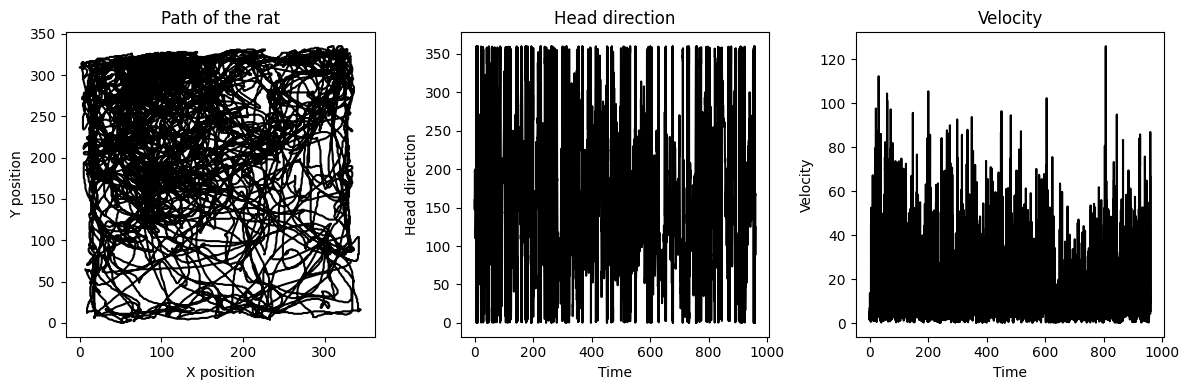

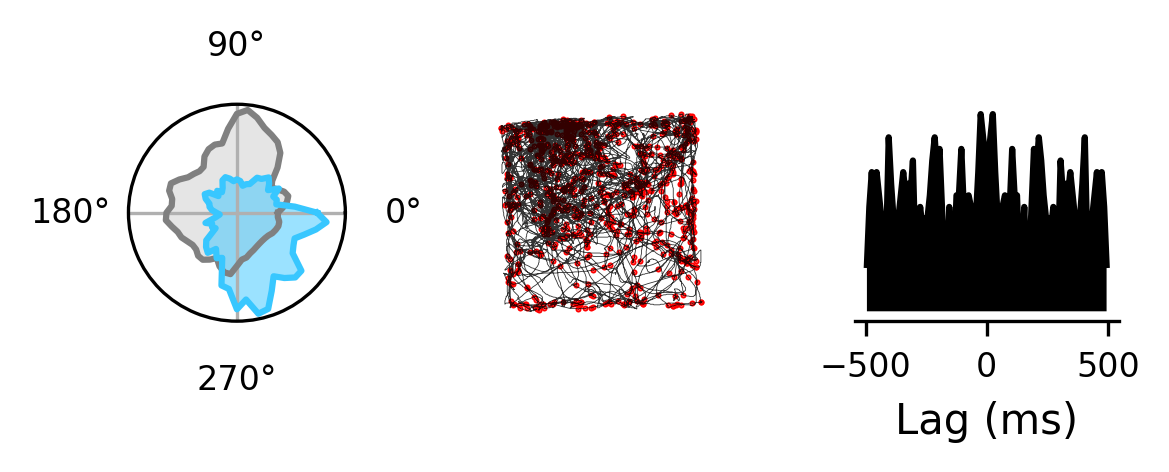

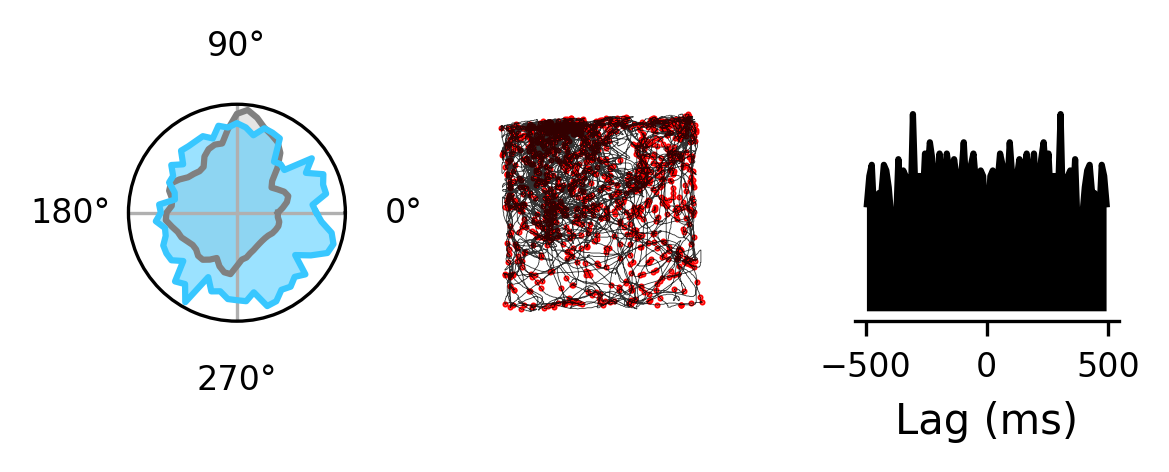

In [3]:
ratname = 'R651'
file_path = '/home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r651/R651_050919_T1_sdata.mat'
data_dict = HD_utils.load_data(ratname, file_path)

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.1,
    'duration_threshold': 1,
    'speed_smooth_sigma': 10
}

if data_dict is not None:
    ppox = data_dict['ppox']
    ppoy = data_dict['ppoy']
    pot = data_dict['pot'].flatten()
    pov = data_dict['pov']
    poh = data_dict['poh'] 
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    ax = axs[0]
    ppox = ppox.astype(float).flatten()
    ppoy = ppoy.astype(float).flatten()
    ax.plot(ppox, ppoy, 'k')
    ax.set_title('Path of the rat')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')

    ax = axs[1]
    ax.plot(pot.flatten(), poh.flatten(), 'k')
    ax.set_title('Head direction')
    ax.set_xlabel('Time')
    ax.set_ylabel('Head direction')

    ax = axs[2]
    ax.plot(pot.flatten(), pov.flatten(), 'k')
    ax.set_title('Velocity')
    ax.set_xlabel('Time')
    ax.set_ylabel('Velocity')

    plt.tight_layout()   
    
    for cell_name, cell_data in data_dict['cells_data'].items():
        
        fig2 = plt.figure(figsize=(4, 1.5), dpi=300)
        gs=fig2.add_gridspec(1, 3, width_ratios=[1, 1.2, 1.2])

        psph = cell_data['psph'].flatten()
        pspt = cell_data['pspt'].flatten()
        spike_phase = cell_data['spike_phase'].flatten()
        pval = cell_data['pval'][0][0]
        hd_mean = cell_data['hd_mean'][0][0]
        hd_std = cell_data['hd_std'][0][0]
        tune_width = cell_data['tune_width'][0][0]
        autocorrelogram = cell_data['autocorrelogram']
        cell_type = cell_data['cell_type']
        
        #compute spike array
        spikearray = HD_utils.compute_spike_array(pspt, pot)
        
        ax0 = fig2.add_subplot(gs[0, 0], projection='polar')
        
        ax0 = plot_head_direction_tuning(ax0, poh, psph, pval, hd_mean, hd_std, tune_width, cell_name, config)
        
        ax1 = fig2.add_subplot(gs[0, 1])
        ax1 = plot_spike_map(ax1, ppox, ppoy, spikearray)
        
        ax2 = fig2.add_subplot(gs[0, 2])

        ax2 = plot_autocorrelogram(ax2, autocorrelogram, cell_type)
        
        plt.tight_layout()    



## save of directional tuning map from all head direction cells

In [4]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData/'
output_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/celltypes/all/'
output_skip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/celltypes/skip'
output_nonskip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/celltypes/nonskip'
output_nontheta_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/celltypes/nontheta/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 5, 
}

# Create output directories if they don't exist
for dir_path in [output_dir, output_skip_dir, output_nonskip_dir, output_nontheta_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)    
    os.makedirs(dir_path)

nontheta_tw = []
theta_tw = []
thetaskip_tw = []   

nontheta_pfr = []
theta_pfr = []
thetaskip_pfr = []

nontheta_ppp = []
theta_ppp = []
thetaskip_ppp = []

nontheta_clr = []
theta_clr = []
thetaskip_clr = []

total_hd_cells = 0

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = HD_utils.load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppox = data_dict['ppox'].astype(float).flatten()
                    ppoy = data_dict['ppoy'].astype(float).flatten()
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        hd_rayleigh = cell_data['hd_rayleigh'][0][0]
                        hd_rayleigh_shuffle_99 = cell_data['hd_rayleigh_shuffle_99'][0][0]                        
                        peak_fr = cell_data['peak_fr'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        cell_type = cell_data['cell_type']
                        
                        spikearray = HD_utils.compute_spike_array(pspt, pot)
                        total_hd_cells += 1
                        if hd_rayleigh > hd_rayleigh_shuffle_99 and peak_fr > 1: #select only head direction tuned cells
                        #if pval < 0.05:
                            try:
                                
                                pval, clr = get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                                
                                #plot
                                fig = plt.figure(figsize=(4, 1.8), dpi=300)
                                gs=fig.add_gridspec(1, 3)
                                
                                #plot head direction tuning map
                                ax0 = fig.add_subplot(gs[0, 0], projection='polar')
                                ax0 = plot_head_direction_tuning(ax0, ppoh, psph, pval, hd_mean, hd_std, tune_width, cell_name, config)
                                
                                #plot spike map
                                ax1 = fig.add_subplot(gs[0, 1])
                                ax1 = plot_spike_map(ax1, ppox, ppoy, spikearray)
                                
                                #plot autocorrelogram, i.e., check theta modulation
                                ax2 = fig.add_subplot(gs[0, 2])
                                autocorrelogram = cell_data['autocorrelogram']
                                ax2 = plot_autocorrelogram(ax2, autocorrelogram, cell_type)
                                
                                tetrode_cell_name = cell_name.split('_')[-2] + ' ' + cell_name.split('_')[-1]
                                fig.suptitle(f"{ratname} {tetrode_cell_name}", fontsize=10, y=0.93)
                                
                                output_path = os.path.join(output_dir, f"{cell_name}.pdf")
                                plt.tight_layout()
                                plt.savefig(output_path)
                                
                                #save fig according to cell type in different folders
                                if 'Strong ThetaxHD' in cell_type:
                                
                                    if 'skip'in cell_type:
                                        thetaskip_tw.append(tune_width)
                                        thetaskip_pfr.append(peak_fr)
                                        thetaskip_ppp.append(pval)
                                        thetaskip_clr.append(clr)
                                        output_skip_path = os.path.join(output_skip_dir, f"{cell_name}.pdf")
                                        plt.savefig(output_skip_path)
                                    elif 'Strong ThetaxHD' in cell_type:
                                        theta_tw.append(tune_width)
                                        theta_pfr.append(peak_fr)
                                        theta_ppp.append(pval)
                                        theta_clr.append(clr)
                                        output_nonskip_path = os.path.join(output_nonskip_dir, f"{cell_name}.pdf")
                                        plt.savefig(output_nonskip_path)
                                        
                                elif 'HDC' in cell_type:
                                    nontheta_tw.append(tune_width)
                                    nontheta_pfr.append(peak_fr)
                                    nontheta_ppp.append(pval)
                                    nontheta_clr.append(clr)
                                    output_nontheta_path = os.path.join(output_nontheta_dir, f"{cell_name}.pdf")
                                    plt.savefig(output_nontheta_path)
                                    
                                plt.close(fig)
                                
                                
                            except Exception as e:  
                                print(f"Error processing {cell_name}: {e}")
                        
print(f"Total number of HD cells processed: {total_hd_cells}")


Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_090819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_230819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_200819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhas

136 158 83
MannwhitneyuResult(statistic=7075.0, pvalue=4.477972171398248e-07)
MannwhitneyuResult(statistic=6004.0, pvalue=0.28266379881607473)
MannwhitneyuResult(statistic=3303.0, pvalue=2.6762130155686187e-07)


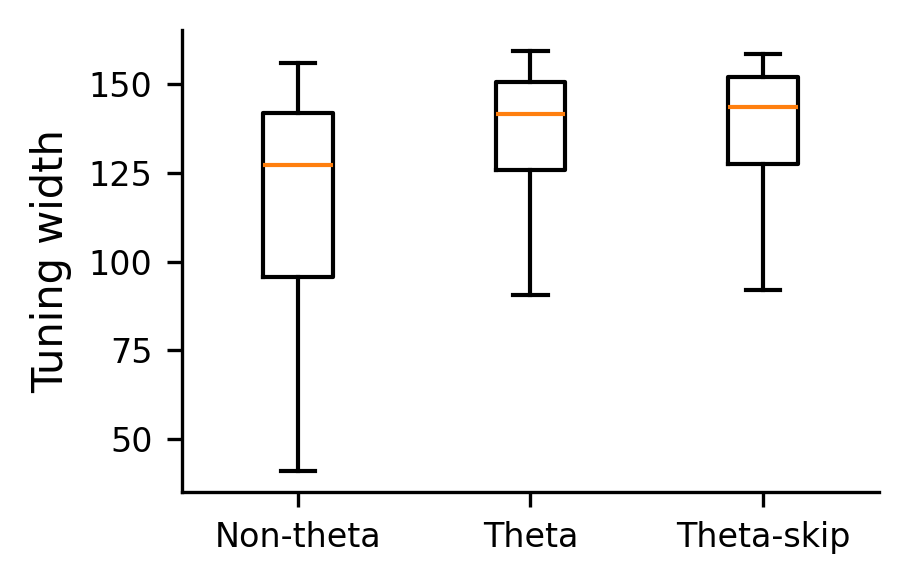

In [58]:
#plot tuning width from three groups in boxplot
fig = plt.figure(figsize=(3, 2), dpi=300)
labelsize = 10
ticksize = 8
ax = fig.add_subplot(111)

ax.boxplot([nontheta_tw, theta_tw, thetaskip_tw], showfliers=False)
ax.set_xticklabels(['Non-theta', 'Theta', 'Theta-skip'])
ax.set_ylabel('Tuning width', fontsize=labelsize)


#ticksize
ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print(len(nontheta_tw), len(theta_tw), len(thetaskip_tw))
#mannwhitneyu test
from scipy.stats import mannwhitneyu
print(mannwhitneyu(nontheta_tw, theta_tw))
print(mannwhitneyu(theta_tw, thetaskip_tw))
print(mannwhitneyu(nontheta_tw, thetaskip_tw))

136 158 83
MannwhitneyuResult(statistic=10262.0, pvalue=0.5076586276752597)
MannwhitneyuResult(statistic=6872.0, pvalue=0.5408317724260419)
MannwhitneyuResult(statistic=5420.0, pvalue=0.623213043404845)


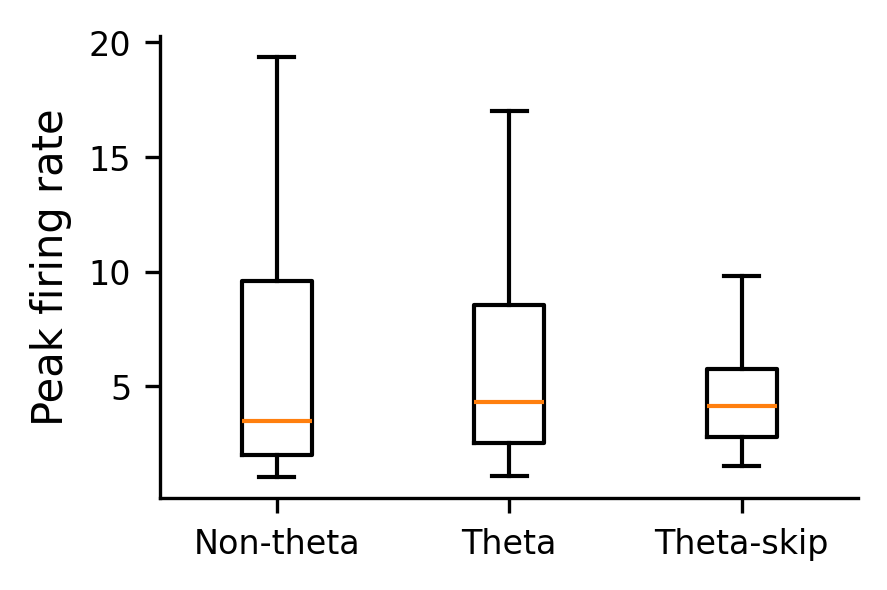

In [59]:
#plot peak firing rate from three groups in boxplot
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = fig.add_subplot(111)
labelsize = 10
ticksize = 8
ax.boxplot([nontheta_pfr, theta_pfr, thetaskip_pfr], showfliers=False)
ax.set_xticklabels(['Non-theta', 'Theta', 'Theta-skip'])
ax.set_ylabel('Peak firing rate', fontsize=labelsize)

#ticksize
ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print(len(nontheta_pfr), len(theta_pfr), len(thetaskip_pfr))
#mannwhitneyu test
from scipy.stats import mannwhitneyu
print(mannwhitneyu(nontheta_pfr, theta_pfr))
print(mannwhitneyu(theta_pfr, thetaskip_pfr))
print(mannwhitneyu(nontheta_pfr, thetaskip_pfr))

MannwhitneyuResult(statistic=7675.0, pvalue=0.7545595412744577)


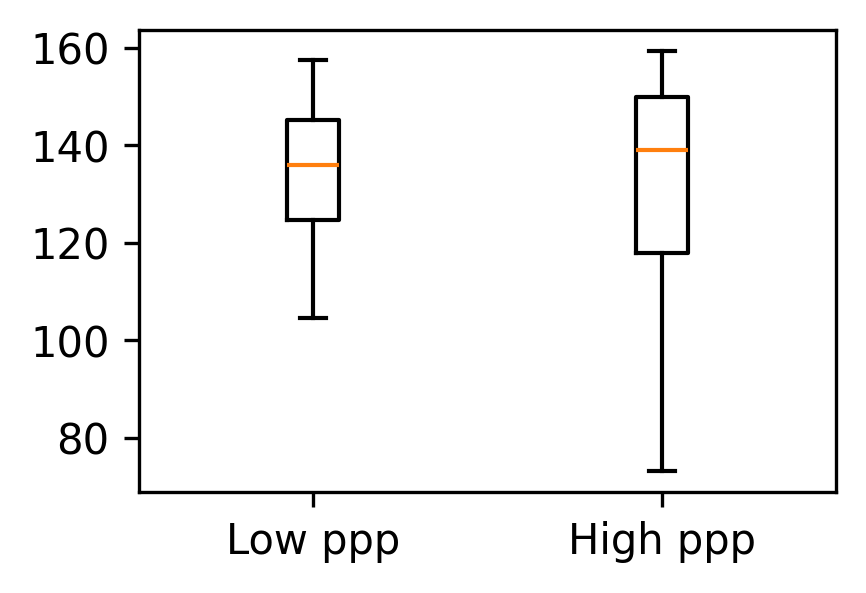

In [60]:
#compare the tuning width of ppp <0.05 and ppp > 0.05
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = fig.add_subplot(111)
labelsize = 10
ticksize = 8

#get the index when both theta_ppp < 0.05 and thetaskip_ppp < 0
ind = (np.array(theta_ppp) < 0.05) & (np.array(theta_clr) < 0)
theta_tw_low = np.array(theta_tw)[ind]
#get the index except the above index
theta_tw_high = np.delete(theta_tw.copy(), ind)

ind = (np.array(thetaskip_ppp) < 0.05) & (np.array(thetaskip_clr) < 0)
thetaskip_tw_low = np.array(thetaskip_tw)[ind]
thetaskip_tw_high = np.delete(thetaskip_tw.copy(), ind)

ind = (np.array(nontheta_ppp) < 0.05) & (np.array(nontheta_clr) < 0)
nontheta_tw_low = np.array(nontheta_tw)[ind]
nontheta_tw_high = np.delete(nontheta_tw.copy(), ind)


#add all low together
low = np.concatenate((theta_tw_low, thetaskip_tw_low, nontheta_tw_low))
high = np.concatenate((theta_tw_high, thetaskip_tw_high, nontheta_tw_high))

ax.boxplot([low, high], showfliers=False)
ax.set_xticklabels(['Low ppp', 'High ppp'])

#mannwhitneyu test
from scipy.stats import mannwhitneyu
print(mannwhitneyu(low, high))
